# Train and Evaluate Model-Interpret Predictions

This notebook will perform steps 6, 7 and 8 and provide an overall conclusion:

6. Train Model
7. Evaluate Model on Test Data
8. Interpret Model Predictions
9. Conclusions

**Imports**

In [1]:
# visualization and manipulation libraries
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.core.pylabtools import figsize
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', 60)

%matplotlib inline
# to display visuals in the notebook

%config InlineBackend.figure_format='retina'
#to enable high resolution plots

# feature prepocessing and split
from sklearn.metrics import mean_squared_error

# machine Learning Models
from sklearn.ensemble import RandomForestRegressor

# to load machine learning model
import pickle

# to visualize a decision tree
import sklearn.tree as tree
import pydotplus
from sklearn.externals.six import StringIO
from IPython.display import Image

# LIME to explain predictions
import lime 
import lime.lime_tabular

# to bypass warnings in section regarding previous imports
import warnings
warnings.filterwarnings('ignore')

/Users/cereniyim/opt/anaconda3/lib/python3.7/site-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)


In [2]:
# functions to use in the notebook
def fit_evaluate_model(model, X_train, y_train, X_valid, y_valid):
    model.fit(X_train, y_train)
    y_predicted = model.predict(X_valid)
    return mean_squared_error(y_valid, y_predicted)

def convert_features_to_array(features):
    num_rows = len(features)
    num_cols = len(features.columns)
    
    features_array = (np
                      .array(features)
                      .reshape((num_rows, 
                                num_cols)))

    return features_array

def convert_target_to_array(target):
    target_array = np.array(target).reshape((-1, ))
    return target_array

**Load data into dataframes**

In [3]:
X_train = pd.read_csv("transformed/X_train.csv")
y_train = pd.read_csv("transformed/y_train.csv")

X_valid = pd.read_csv("transformed/X_valid.csv")
y_valid = pd.read_csv("transformed/y_valid.csv")

test_features = pd.read_csv("transformed/test_features.csv")
test_target = pd.read_csv("transformed/test_target.csv")

In [4]:
# convert to train, valid, test sets to array
X_train_array = convert_features_to_array(X_train)
y_train_array = convert_target_to_array(y_train)

X_valid_array = convert_features_to_array(X_valid)
y_valid_array = convert_target_to_array(y_valid)

X_test_array = convert_features_to_array(test_features)
y_test_array = convert_target_to_array(test_target)

In [5]:
# convert merged train and target sets to array
X = pd.concat([X_train, X_valid])
y = pd.concat([y_train, y_valid])

X_array = convert_features_to_array(X)
y_array = convert_target_to_array(y)

**Load & Train Random Forests Model**

In [6]:
#random_forest_model = (pickle
#                       .load(
#                           open('random_forests_model.sav', 
#                                'rb')))

In [7]:
random_forest_model = RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                                            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                                            max_samples=None, min_impurity_decrease=0.0,
                                            min_impurity_split=None, min_samples_leaf=2,
                                            min_samples_split=4, min_weight_fraction_leaf=0.0,
                                            n_estimators=200, n_jobs=None, oob_score=False,
                                            random_state=42, verbose=0, warm_start=False)

**Recall Established MSE Baseline**

***Mean square error (MSE)*** is the average of sum of squared residuals where a ***residual*** is the a difference between the actual and predicted value of a target variable.

In [8]:
# set baseline as mean of training set's target value
baseline = np.mean(y_train_array)

# calculate MSE 
mse_baseline = (np
                .mean(np
                      .square(baseline - y_valid_array)))

print("Baseline mse is:", round(mse_baseline, 2))

Baseline mse is: 9.01


This shows that on average variance between the training points and validation points are 9.01. In other words, sum of squared residuals of average of training points to the validation points is 9.01.

If our random forest model can significantly lower this variance, we can be confident that the model is a good-predictor, and a machine learning approach is applicable to this problem.

## Train Model

Several models are tried out in the previous notebook and random forest regressor from scikit-learn library is decided as final model because it has proved that it is a good predictor with ease of model explainability  and reasonable run-times.

Random forests algorithm is an ensemble model built on multiple decision trees. To understand how model works, first we should understand how a decision tree works.

A ***decision tree*** is tree-like structure and uses its structure to make predictions. It breaks down a dataset into smaller and smaller subsets while at the same time an associated decision tree is incrementally developed. The final result is a tree with decision nodes and leaf nodes. A decision node has two or more branches, each representing values for the feature tested. Leaf node represents a final decision on the target.

***Random forest algorithm*** is an algorithm that builds multiple decision trees once and trains them on various sub-samples and various subsets of the features of the dataset. It's random selection of dataset and features subsamples makes this algorithm more robust to over-fitting.

In [9]:
%%time
random_forest_model.fit(X_array, y_array)

CPU times: user 1.23 s, sys: 20.3 ms, total: 1.25 s
Wall time: 1.25 s


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='sqrt', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=2,
                      min_samples_split=4, min_weight_fraction_leaf=0.0,
                      n_estimators=200, n_jobs=None, oob_score=False,
                      random_state=42, verbose=0, warm_start=False)

**Visualize a decision tree from random forest model:**

In [10]:
single_tree = random_forest_model.estimators_[134]

In [11]:
dot_data = StringIO()
tree.export_graphviz(single_tree,
                     out_file=dot_data,
                     # the target names.
                     # class_names=breast_cancer.target_names,
                     # the feature names.
                     feature_names=list(test_features.columns),
                     filled=True,  # Whether to fill in the boxes with colours.
                     # Whether to round the corners of the boxes.
                     rounded=True,
                     special_characters=True, 
                     max_depth = 3)

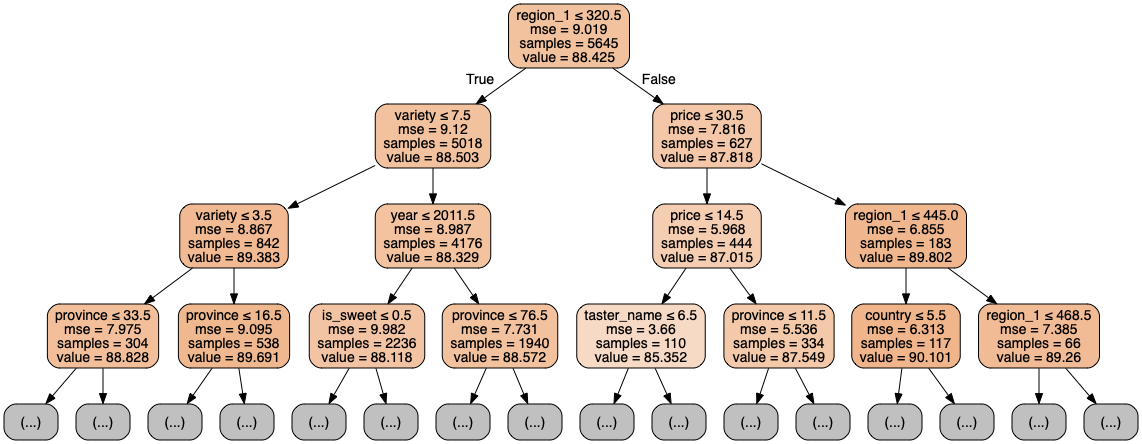

In [12]:
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())
Image(graph.create_png())

A single decision tree from random forest model is helpful to understand how our model makes it predictions. Although this is tree visualized with only first 3 nodes, it conveys a great deal of information. This is tree is also a good example of random selection of features and sample sizes in each node.

For example, the root node first asks if the region_1 is less than 320.5 and answers this question using a subset of the training dataset of size 5645. It can be easily realized that initial MSE is same as our common-sense baseline estimate of MSE. Value of the target is 88.425.

The true child node asks if the variety is less than 7.5 and answers this question using a subset of the training dataset of size 5018. The MSE is almost same as previous node's MSE. Value of the target is 88.503.

False child node asks if the price is less than 30.5 and answers this question using a subset of the training dataset of size 627. The MSE is improved in this node, as an indicator of more coherent node. Value of the target value of 87.818.

When a node's MSE does not improve further or when an internal node is left with minimum 2 samples (as we decided in the hyperparameter tuning part) decision tree reaches its leaf nodes. Final predictions are generated by averaging the results of all decision trees.

## Evaluate Model on Test Data

We are going to generate our predictions by feeding our test_features into the random forests model.

In [13]:
predictions = (random_forest_model
               .predict(X_test_array))

In [14]:
%%time
mse_test = fit_evaluate_model(random_forest_model,
                              X_array,
                              y_array,
                              X_test_array,
                              y_test_array)

print("MSE of the test set is {}"
      .format(round(mse_test,2)))

MSE of the test set is 4.93
CPU times: user 1.3 s, sys: 26.3 ms, total: 1.32 s
Wall time: 1.32 s


Our evaluation of the test with the random forests algorithm has significantly lowered the baseline estimate, it is decreased from 9.01 to 4.93 showing 45% improvement. This serves as a proof that our wine rating predictor is a good predictor of points and can be a useful product for our online-wine-seller client.

## Interpret Model Predictions

### Actuals VS predicted points

In [15]:
def PlotPredictedVSActual(predictions, actuals):
    figsize(20, 10)
    plt.rcParams['font.size'] = 14

    # histogram of predictions
    ax = plt.subplot(121)
    ax.hist(predictions,
            bins=10, 
            color = "#971539", 
            edgecolor = 'white')
    ax.set_xlabel("points", size=14)
    ax.set_xticks(range(80, 101))
    ax.set_ylabel("count", size=14)
    ax.set_title("Predicted Distribution", size=16)
    plt.grid(b=True, axis = 'y', alpha=0.3)

    # histogram of actual values
    ax2 = plt.subplot(122)
    ax2.hist(actuals,
             bins=20, 
             color = "#971539", 
             edgecolor = 'white')
    ax2.set_xlabel("points", size=14)
    ax2.set_xticks(range(80, 101))
    ax2.set_ylabel("count", size=14)
    ax2.set_title("Actual Distribution", size=16)
    plt.grid(b=True, axis = 'y', alpha=0.3)

    # plt.savefig("PredictionsVSActuals.png")

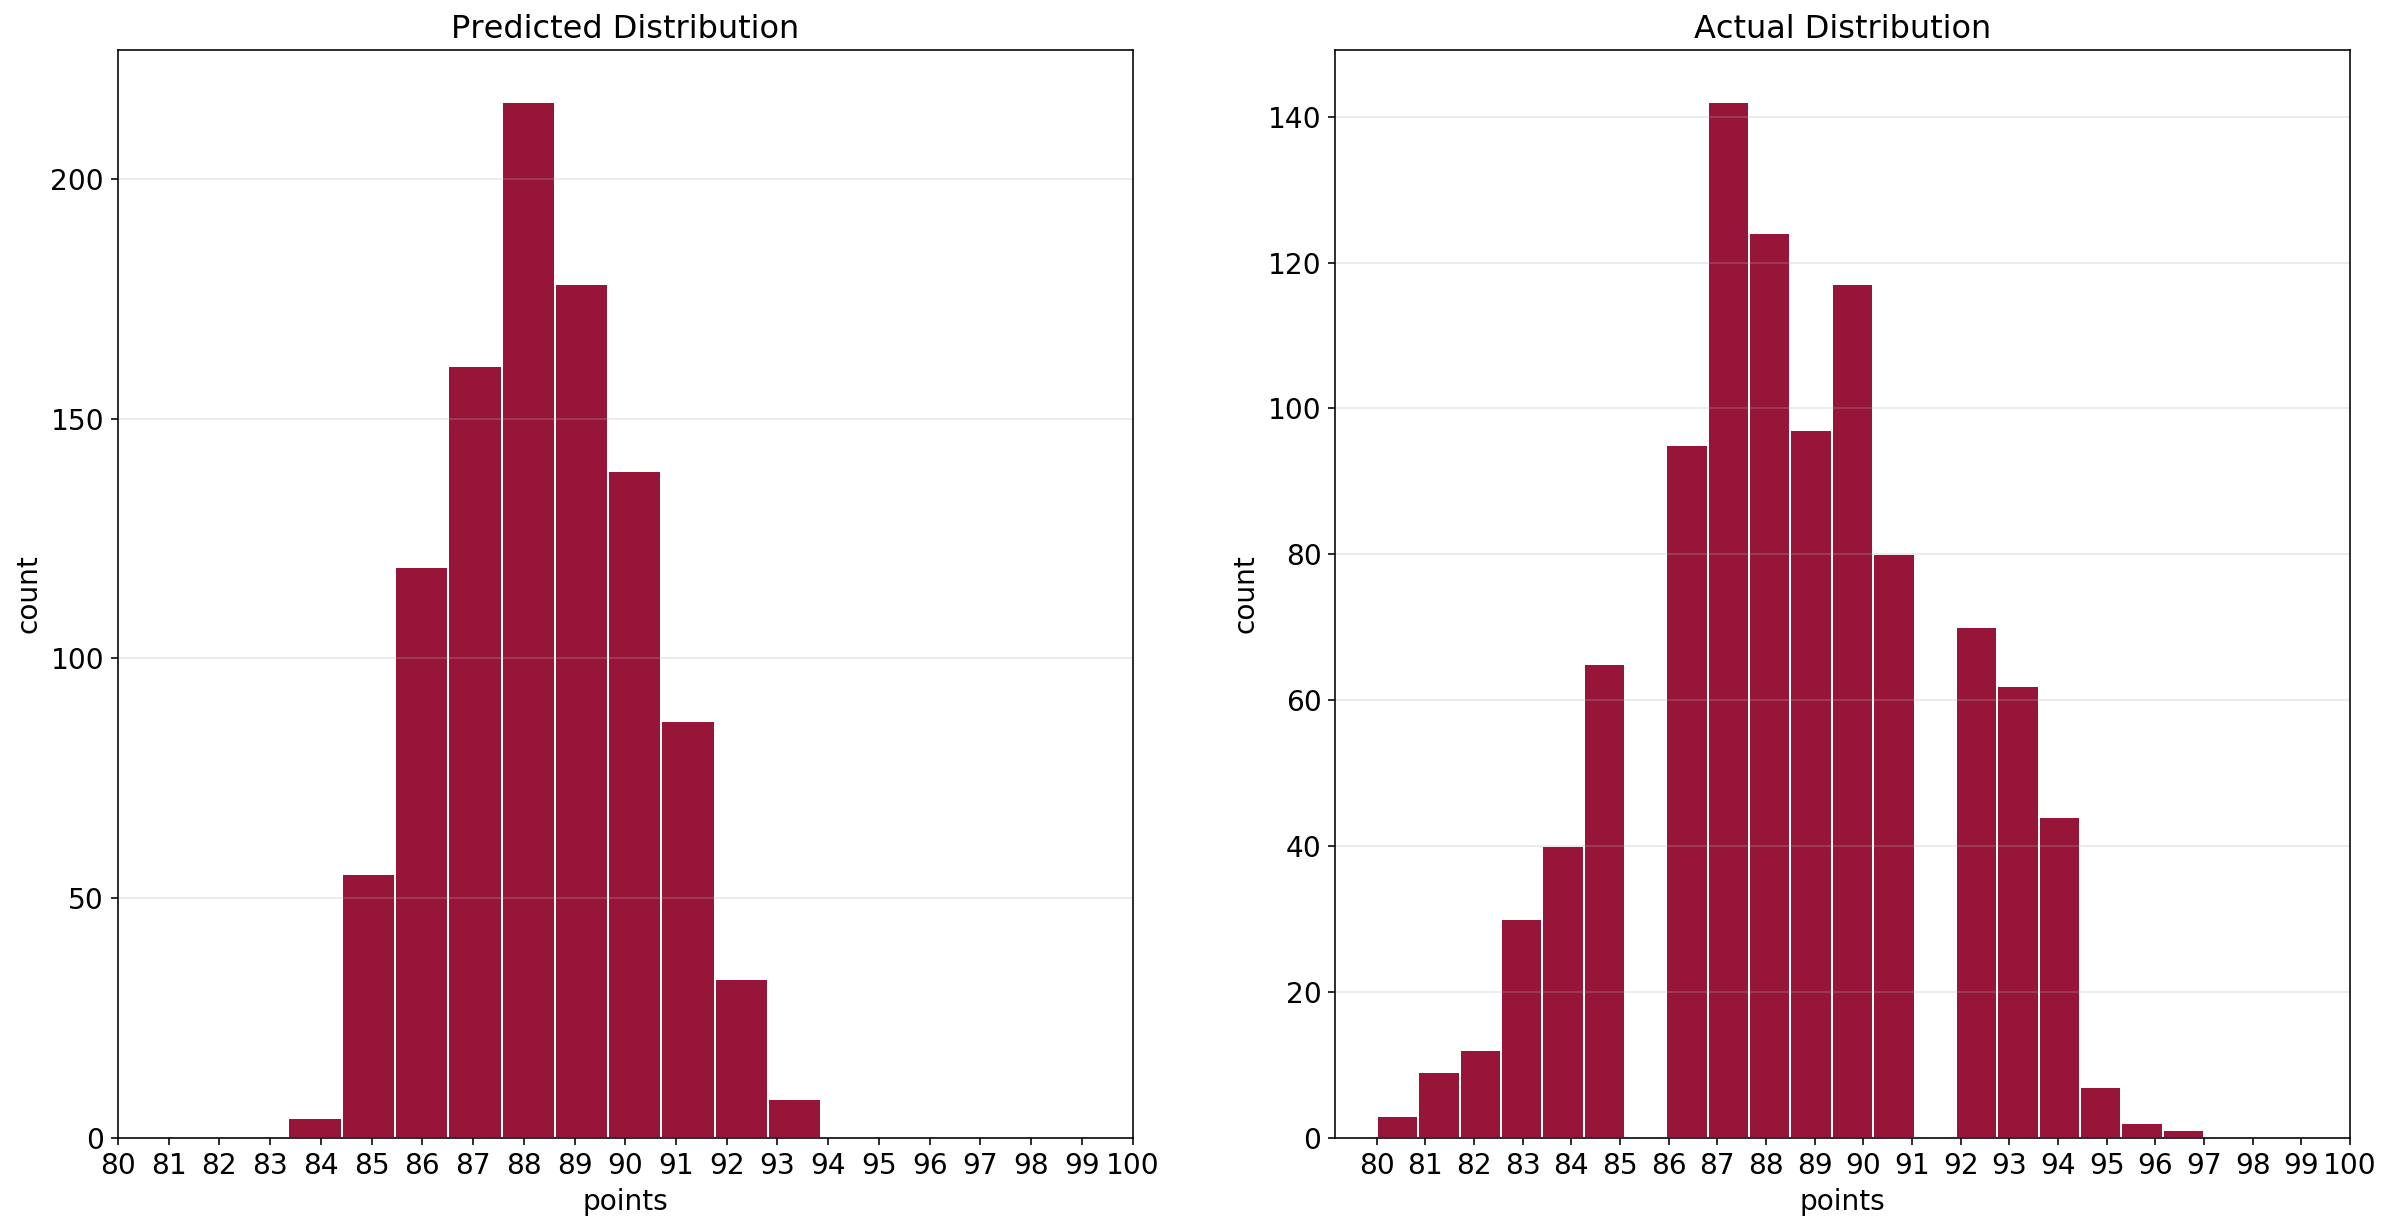

In [16]:
PlotPredictedVSActual(predictions, y_test_array)

Actual distribution is wider than our predictions. Our model was able to predict points within 84 and 94 and was not able to predict the outliers or less-frequent points:

* points below 84
* points above 94

This can be a further and interesting improvement area for our wine rating predictor, but we will not touch it for now. We already satisfied project requirements and it is important to stay in the boundaries of project scope.

### Interpret feature importances

In [17]:
def PlotFeatureImportances(model, feature_names):
    feature_importances = (pd
                           .DataFrame(
                               {'feature': feature_names,
                                'importance': model
                                .feature_importances_}))

    feature_importances = (feature_importances
                           .sort_values(by="importance",
                                        ascending=False))
    figsize(20, 10)
    plt.rcParams['font.size'] = 14
    sns.set(font_scale=1.5, style="whitegrid")

    # set color
    labels = np.array(feature_importances.feature)
    values = np.array(feature_importances.importance) 
    colors = ["#808080" if (y < max(values))
              else "#971539" for y in values]

    # set the plot
    ax = sns.barplot(x="importance", 
                     y="feature", 
                     data=feature_importances, 
                     palette = colors)

    # set title and save plot
    plt.title("Feature Importances", size =16)
    # plt.savefig("FeatureImportances.png")

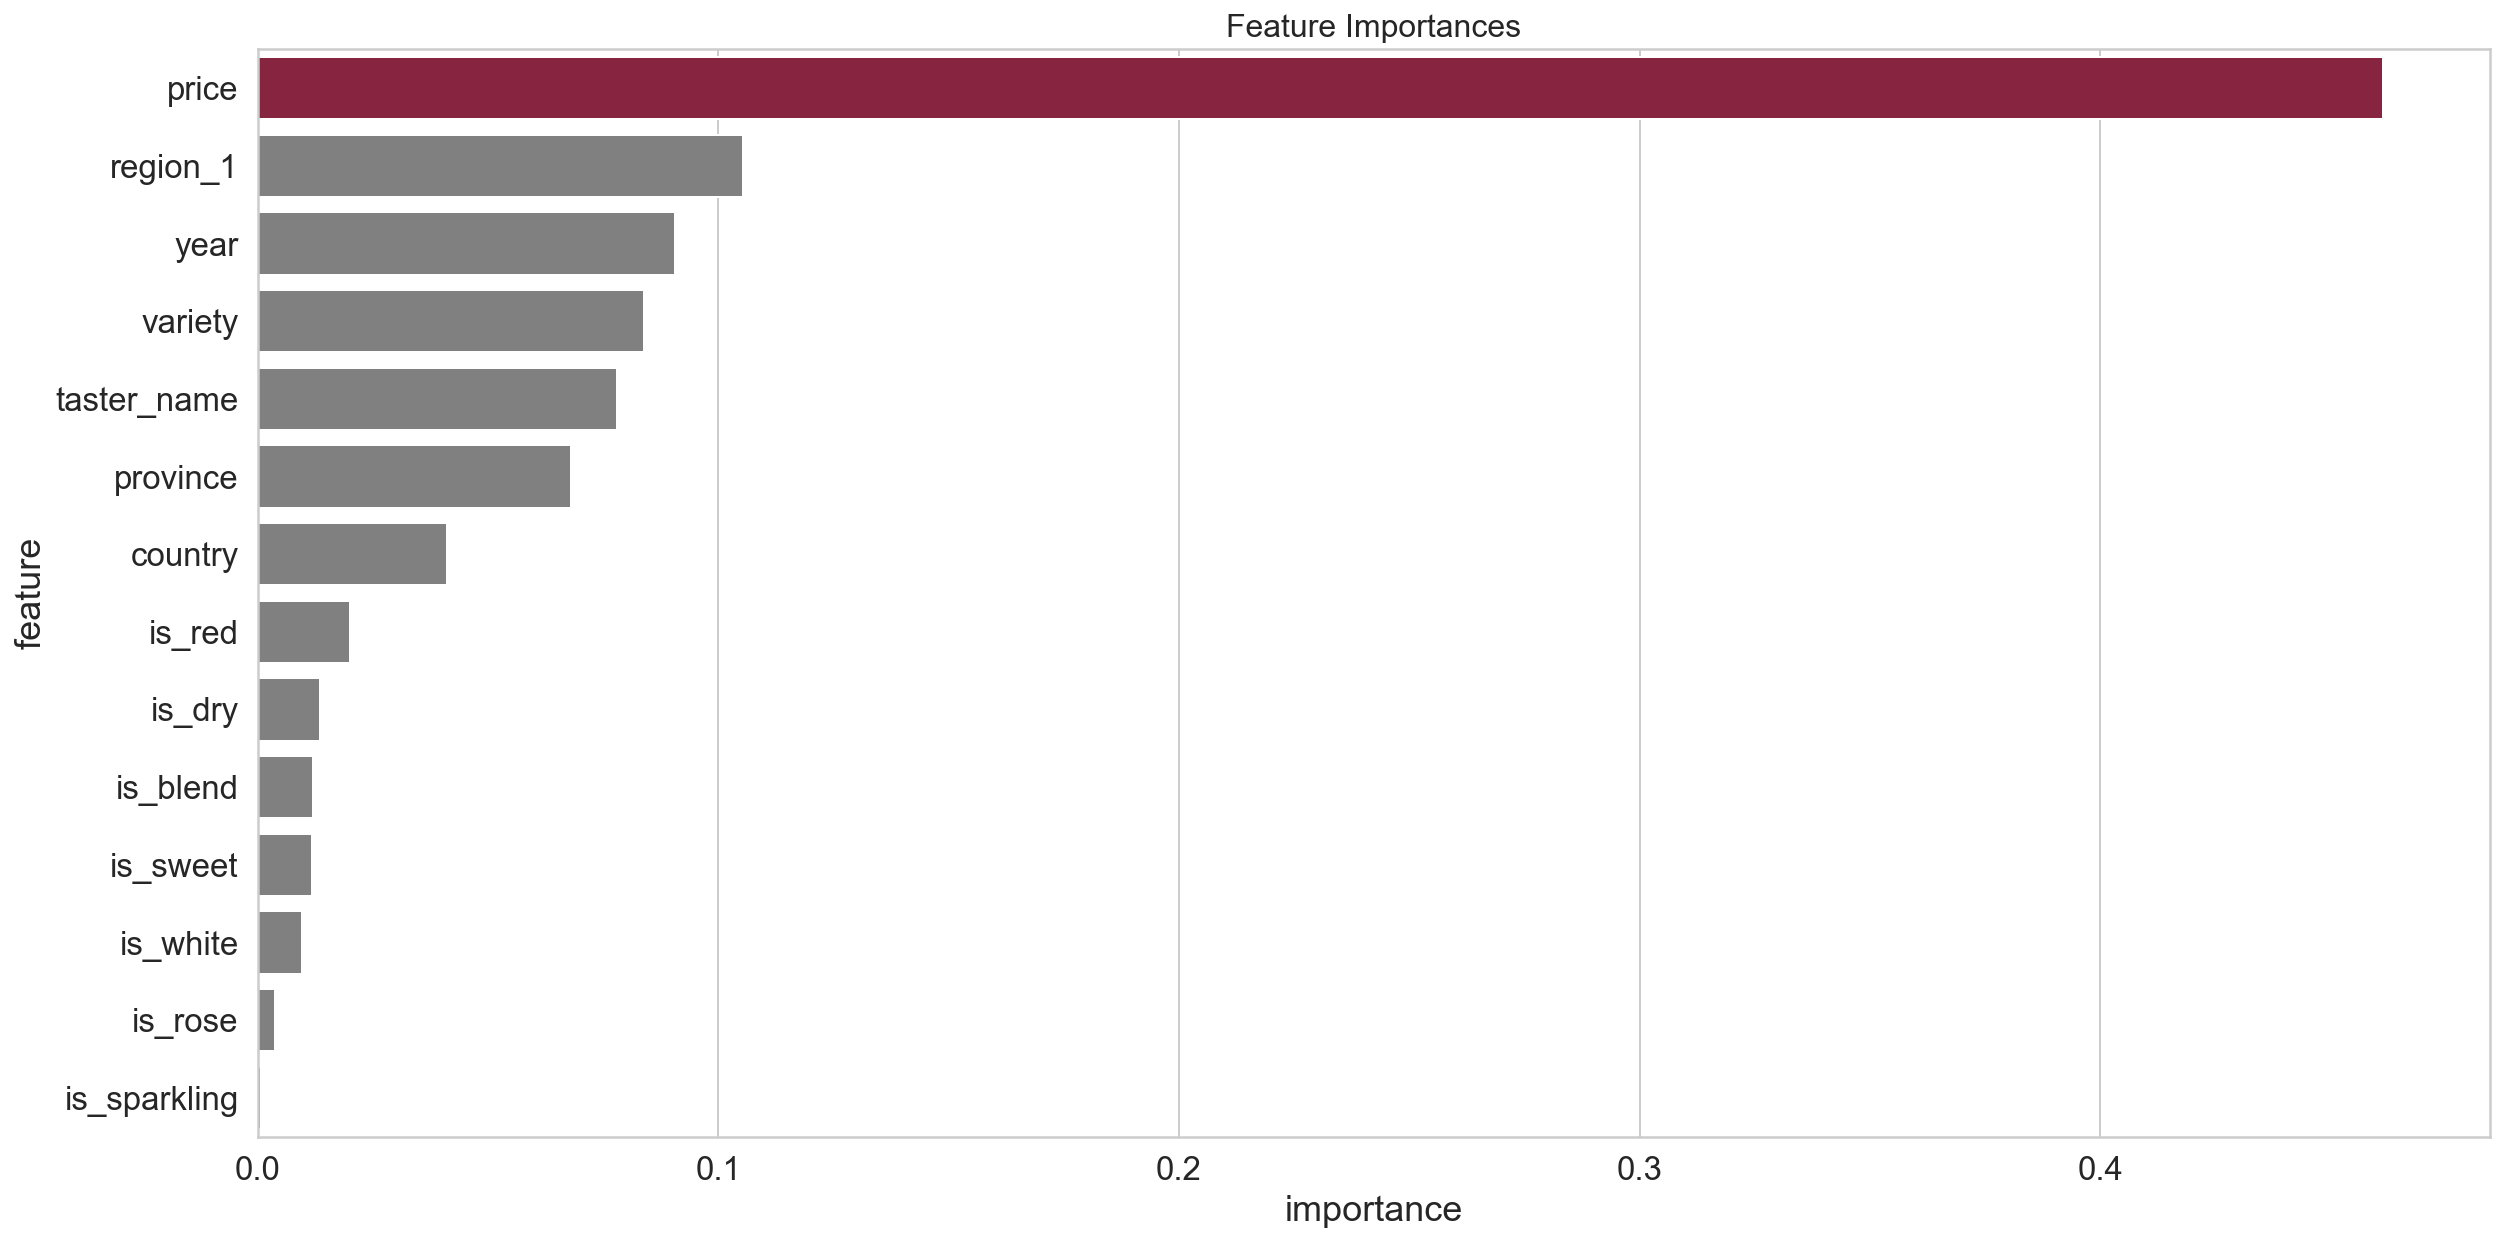

In [18]:
PlotFeatureImportances(random_forest_model, 
                       test_features.columns)

In [19]:
# Extract the feature importances into a dataframe
feature_importances = (pd
                       .DataFrame(
                           {'feature': test_features.columns,
                            'importance': random_forest_model
                            .feature_importances_}))

feature_importances = (feature_importances
                       .sort_values(by="importance", 
                                    ascending=False))

In [20]:
feature_importances

,feature,importance
4,price,0.461451
2,region_1,0.105392
5,year,0.090605
3,variety,0.083888
6,taster_name,0.078003
1,province,0.068073
0,country,0.041124
7,is_red,0.020019
11,is_dry,0.013572
13,is_blend,0.011932


According to the random forest model, the most importance features for predicting the points of a wine is price, region_1, year, variety and taster_name.

These are inline with our preliminary observations developed during *Exploratory Data Analysis* part. From the features extracted, production year is the most important among them and whether a wine is sparkling or not is the least important predictor of points.

Another significant observation is note and taste related features extracted from variety and description features become moderately-important features for our predictor. A comprehensive text-mining and sentiment analysis may help finding more valuable features from description and variety features. This can also help model to predict higher and lower points wines.

### Example from a correct and wrong predicton

We will try to explain the predictions that our model gets very wrong and an example the model gets correct. To observe that we are going to look at the maximum of the residuals and minimum of the residuals and use LIME (Locally Interpretable Model-agnostic Explanations) library.

#### Wrong prediction

In [21]:
# find the residuals
residuals = abs(predictions - y_test_array)

# Exact the worst and best prediction
wrong = X_test_array[np.argmax(residuals), :]
right = X_test_array[np.argmin(residuals), :]

In [22]:
# Create a lime explainer object
explainer = lime.lime_tabular.LimeTabularExplainer(training_data = X_array, 
                                                   mode = 'regression',
                                                   training_labels = y_array,
                                                   feature_names = test_features.columns)

Prediction: [90.33783208]
Actual Value: 82


Text(0.5, 0, 'Effect on Prediction')

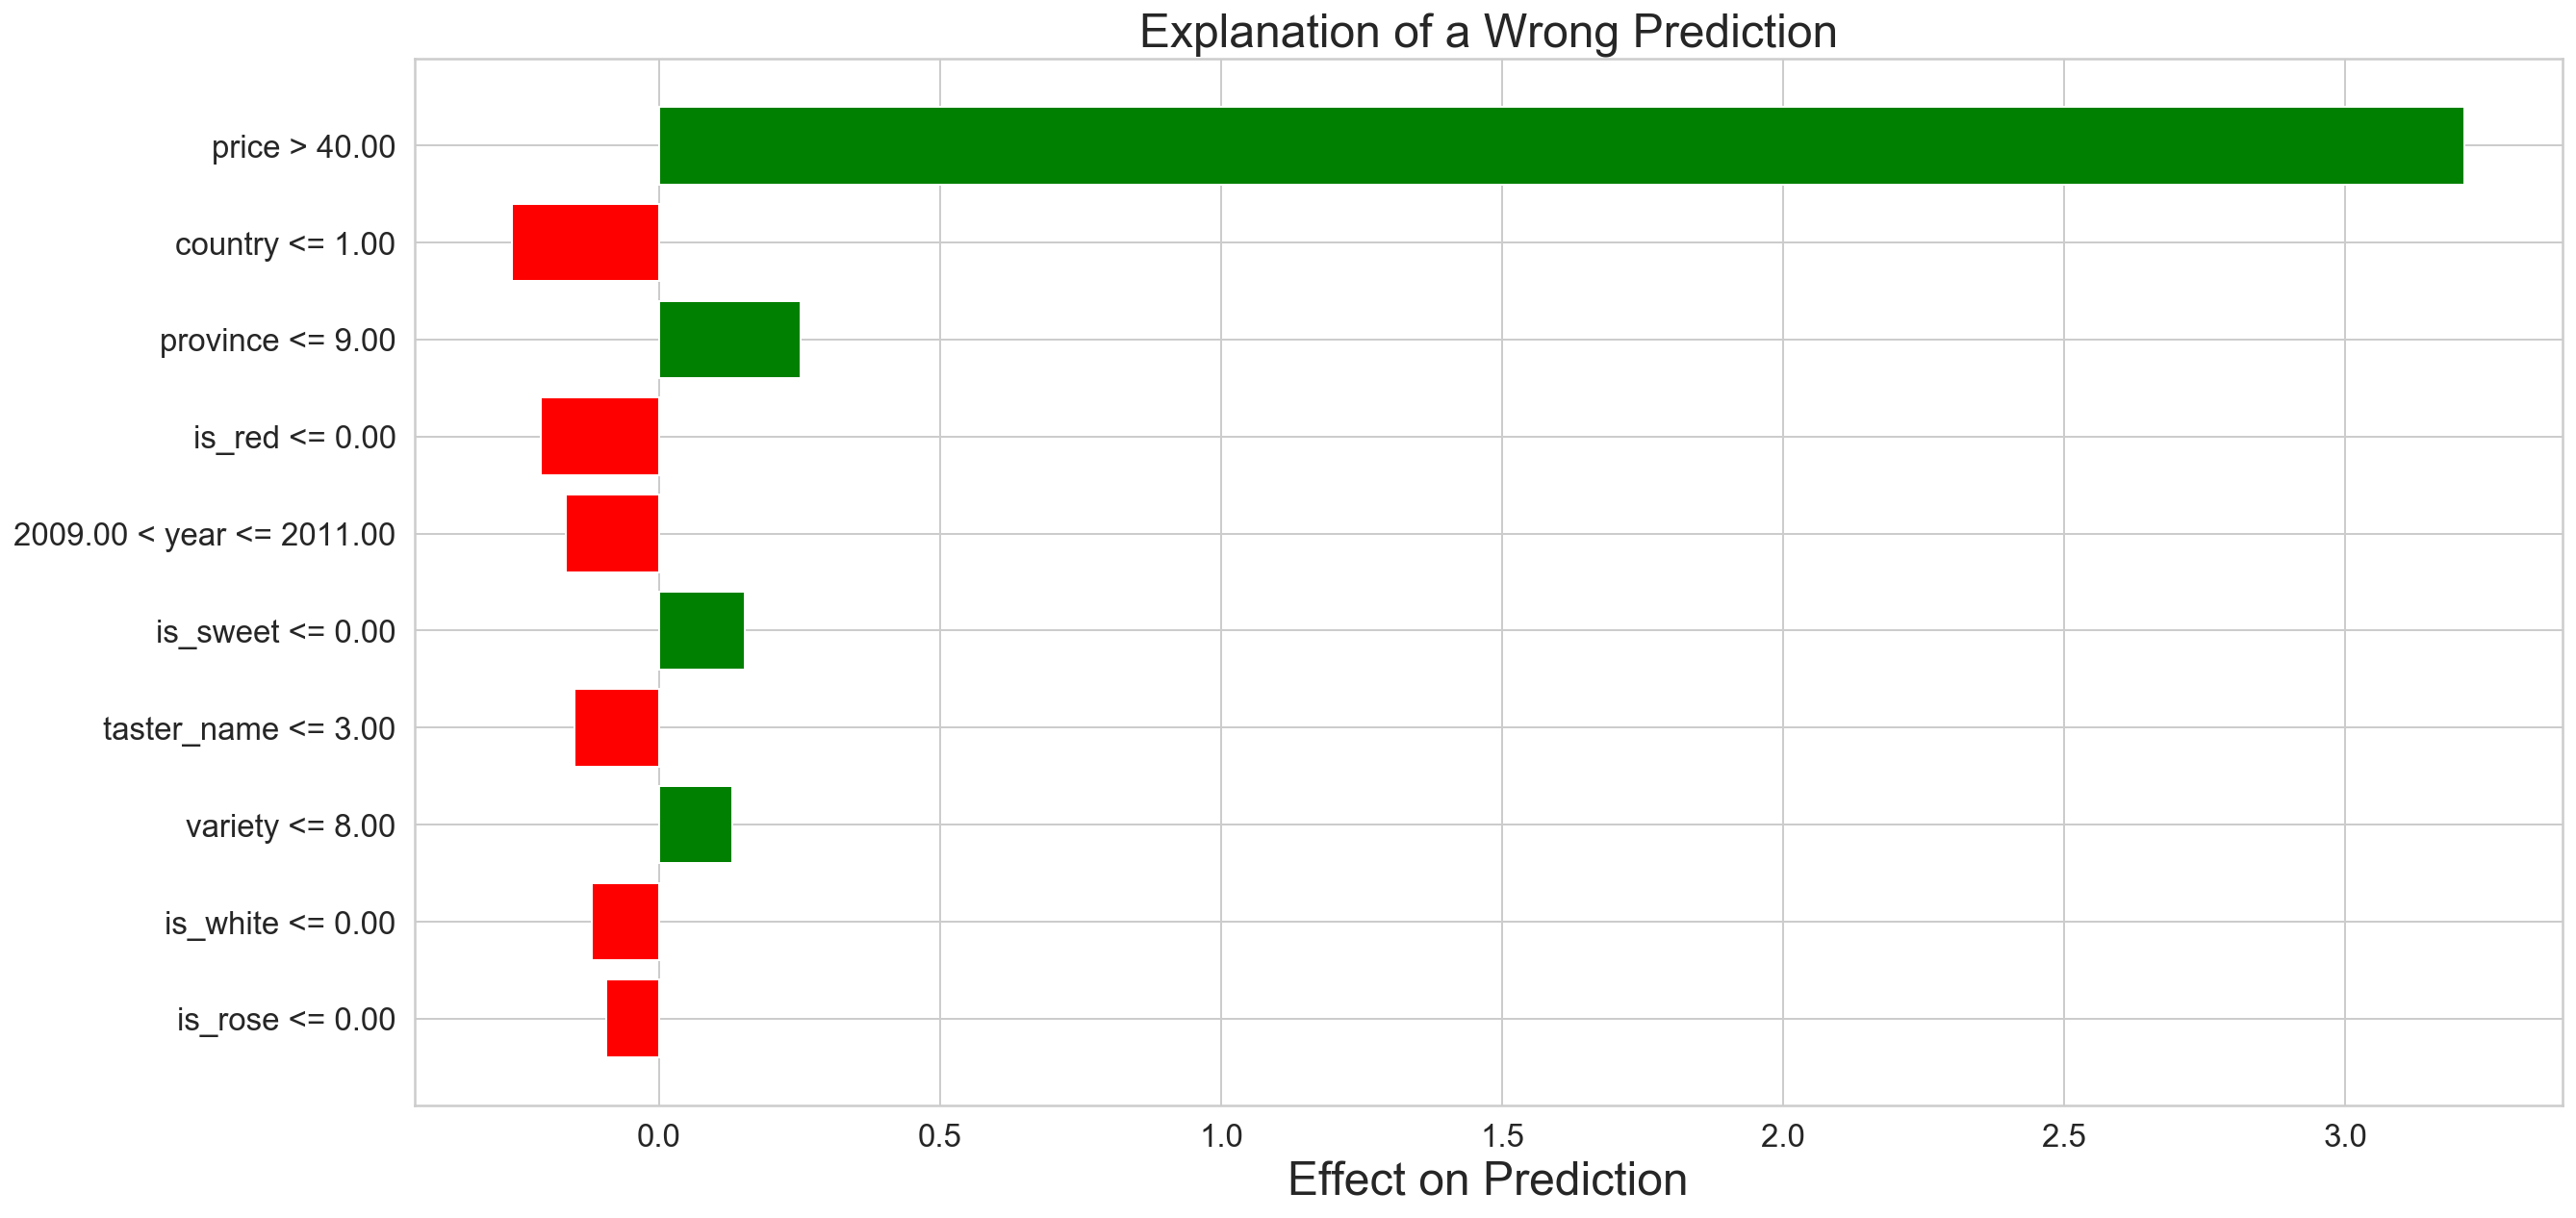

In [23]:
# Display the predicted and true value for the wrong instance
print('Prediction: {}'
      .format(random_forest_model.predict(wrong.reshape(1, -1))))
print('Actual Value: {}' 
      .format(y_test_array[np.argmax(residuals)]))

# Explanation for wrong prediction
wrong_exp = explainer.explain_instance(data_row = wrong, 
                                       predict_fn = random_forest_model.predict)

# Plot the prediction explaination
figsize(20, 10)
plt.rcParams['font.size'] = 24
wrong_exp.as_pyplot_figure()
plt.title('Explanation of a Wrong Prediction', size = 24)
plt.xlabel('Effect on Prediction', size = 24)

In this example, our model predicted a score of 90 when it is actually 82.

The plot from LIME is showing us the contribution to the prediction from each of the features. For example, positive contributions are colored in green and negative contributions are colored in red in the plot above.

We can see that the price significantly increased the prediction because it was above 40. Country and is_red decreased the prediction slightly since is_red value was 0 and country was 1 which is the value for US.

Let's go through the same process with a prediction the model got correct.

#### Right prediction

Prediction: [87.00346181]
Actual Value: 87


Text(0.5, 0, 'Effect on Prediction')

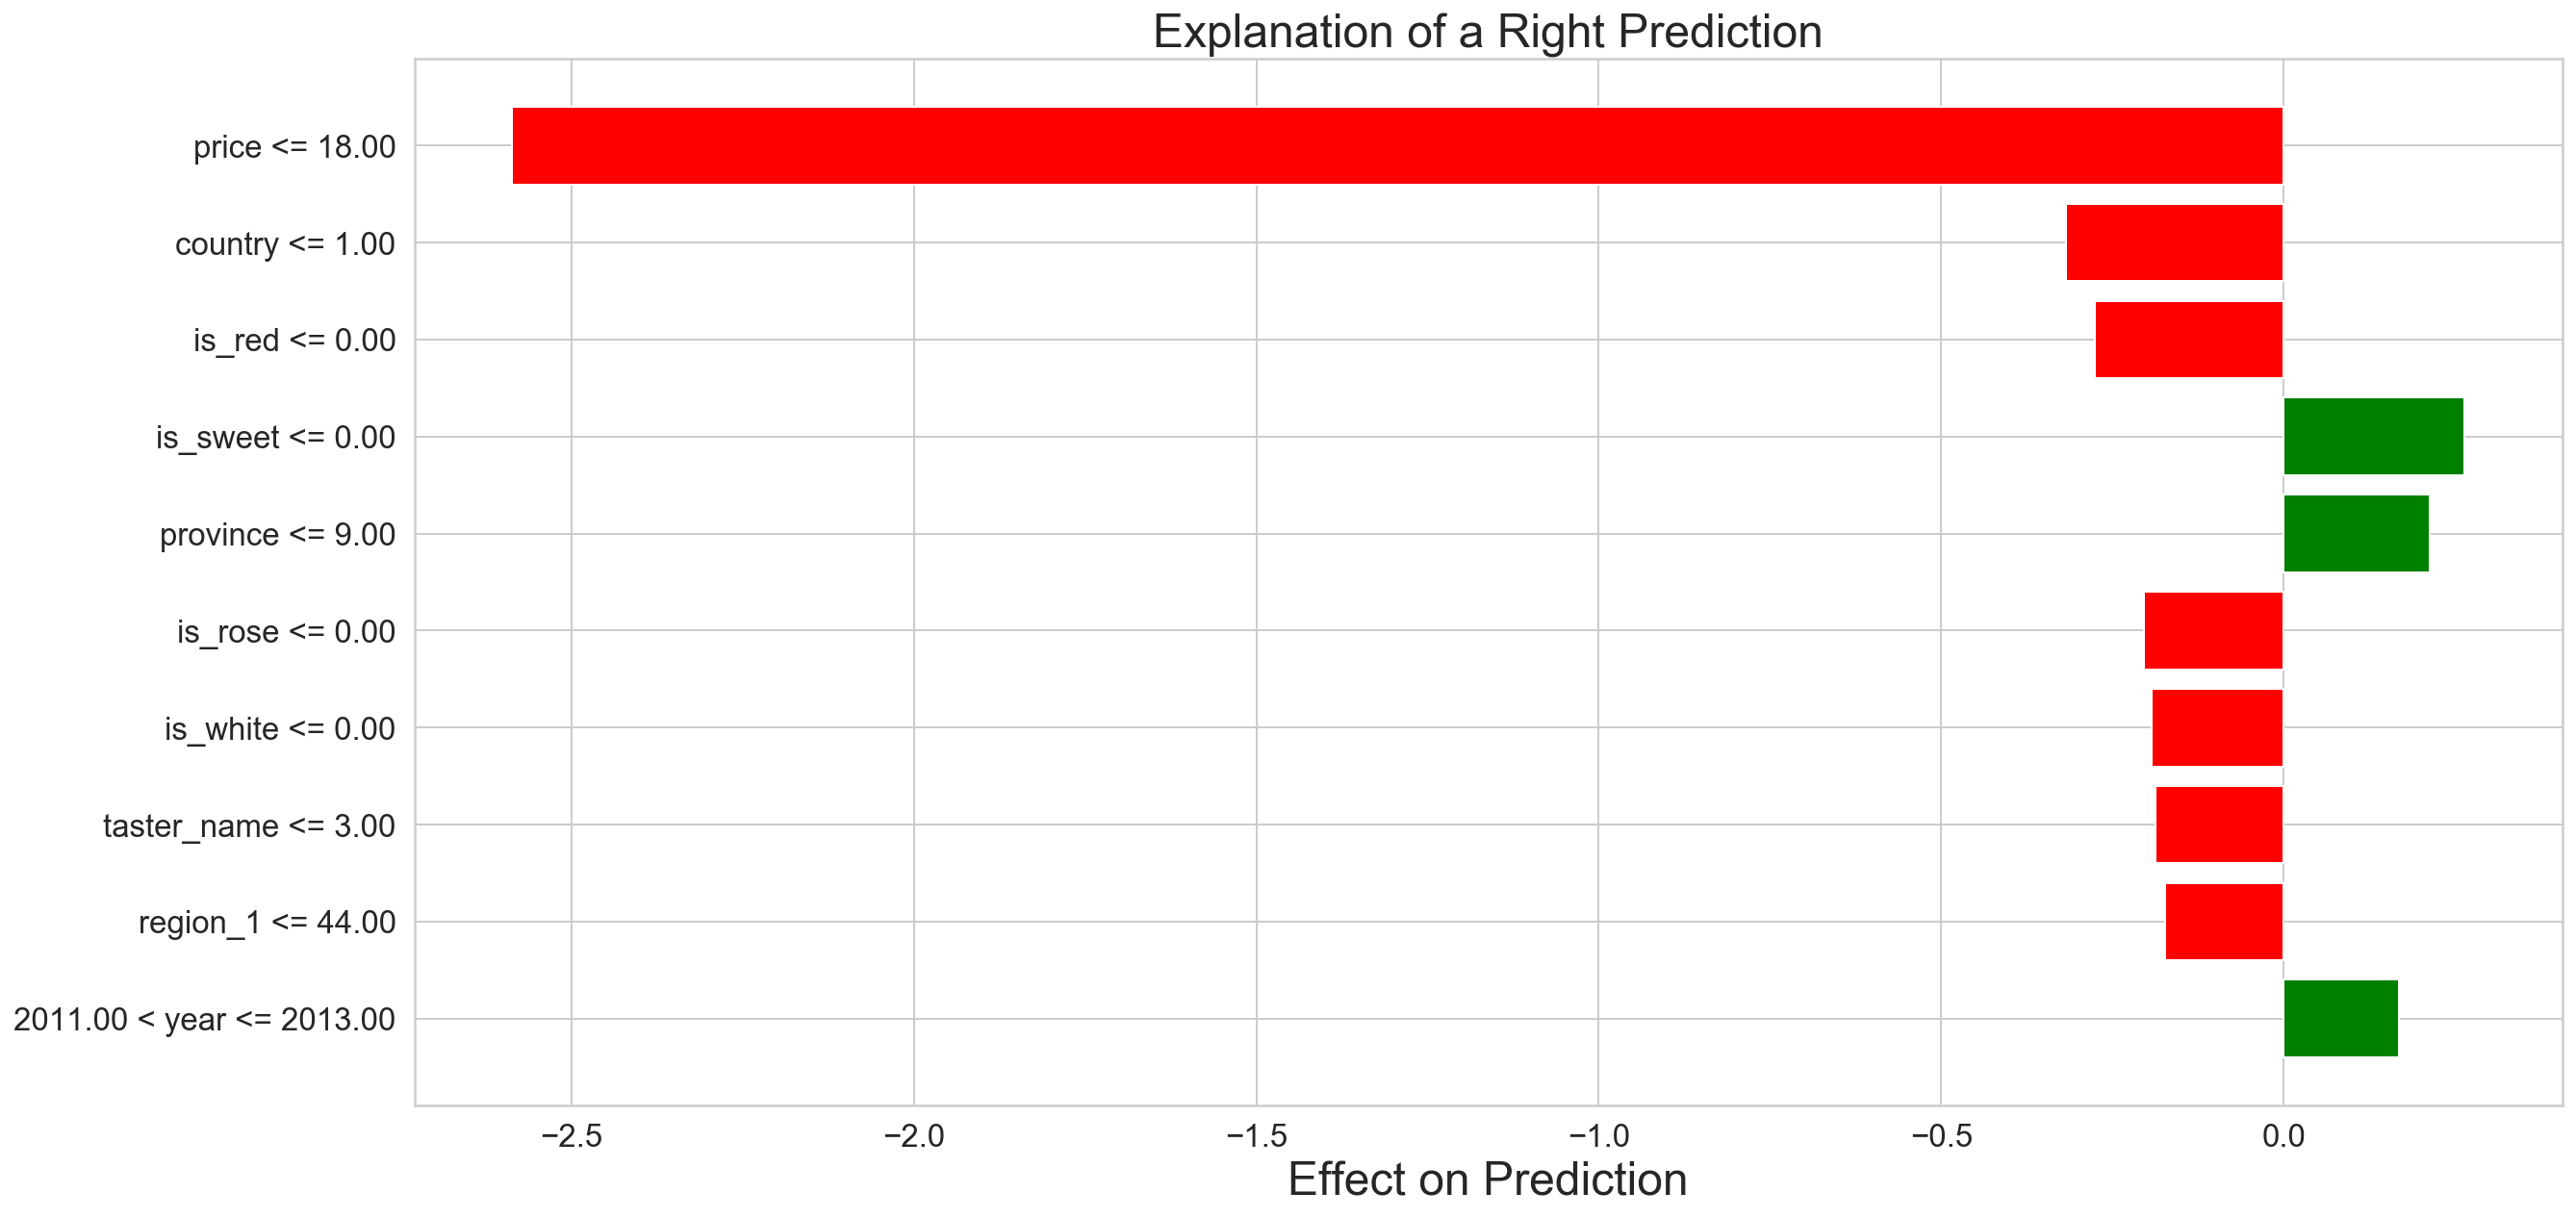

In [24]:
# Display the predicted and true value for the wrong instance
print('Prediction: {}'
      .format(random_forest_model.predict(right.reshape(1, -1))))
print('Actual Value: {}' 
      .format(y_test_array[np.argmin(residuals)]))

# Explanation for wrong prediction
right_exp = explainer.explain_instance(data_row = right, 
                                       predict_fn = random_forest_model.predict)

# Plot the prediction explaination
figsize(20, 10)
plt.rcParams['font.size'] = 24
right_exp.as_pyplot_figure()
plt.title('Explanation of a Right Prediction', size = 24)
plt.xlabel('Effect on Prediction', size = 24)

Price lower than 18 decreased the predictions, so the other features except province. Another valuable observation is that this is the prediction that our model got right, even in that case there is 0.003 difference between the actual and the predicted points.

## Conclusions

We set out to answer the question: We set out to answer the question: Can we build a good wine predictor using machine learning models to predict  points of a wine and which set of features can be used for that? Given the results of the 3 notebooks, conclusion is **yes!**

The two most important findings of the wine rating predictor is:

**1. Using the given wine dataset and current set of features, we created a random forest model to infer the points of a wine with a reasonable variance of 4.9. Our model significantly lowered (45%) the common-sense baseline, serving as an evidence to our positive answer to the initial question**

**2. We used features price, region, production year, variety of the grapes, taster name, province, country, color of the wine (red, white, rose) taste of the wine (dry, sweet, sparkling), blend of a wine. The most useful predictors turned out to be price, region_1, year, variety of the grapes and a taster name.**
 
Further Improvement Areas:

Extending prediction range: so that the less-frequent target values can be predicted by the model. The current sample dataset is dominated by wines from the most dominant countries (US, Italy, France, Spain), feeding more data from non-present countries might help the model to learn better the determiners of the less-frequent points.

Using NLP to extract stronger predictors: currently, the strongest predictor is “price”. Extracting more features from the description related to wine taste and notes can help create strong predictors like price, decreasing prediction error of the model.
